In [1]:
import pandas as pd

# Load the uploaded dataset
file_path = '/Users/arlankalin/Downloads/Cyberbullying-emotion-main/data/final_dataset_with_normal.csv'
df = pd.read_csv(file_path)

# Check basic info
df.info(), df['label'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3690 entries, 0 to 3689
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    3690 non-null   object
 1   label   3690 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 57.8+ KB


(None,
 label
 0    1747
 1    1261
 3     433
 2     249
 Name: count, dtype: int64)

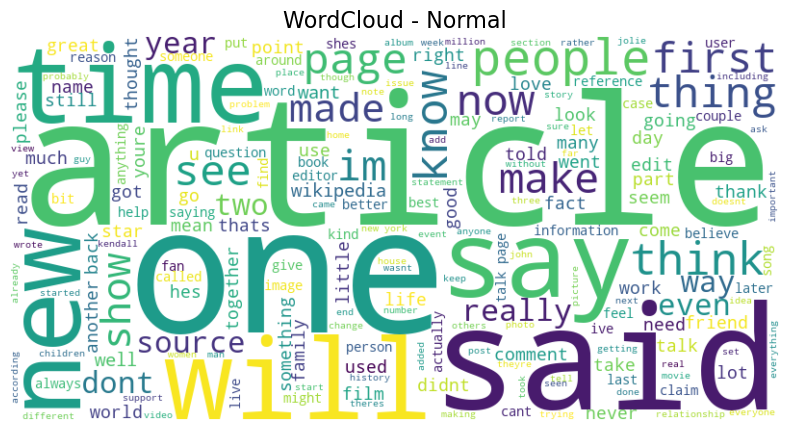

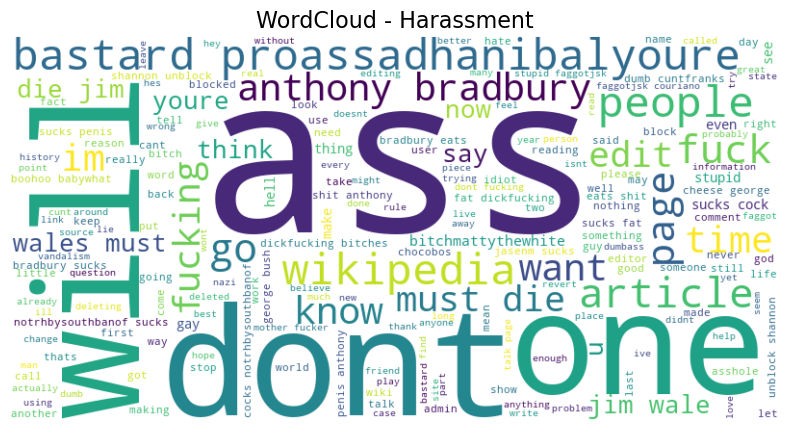

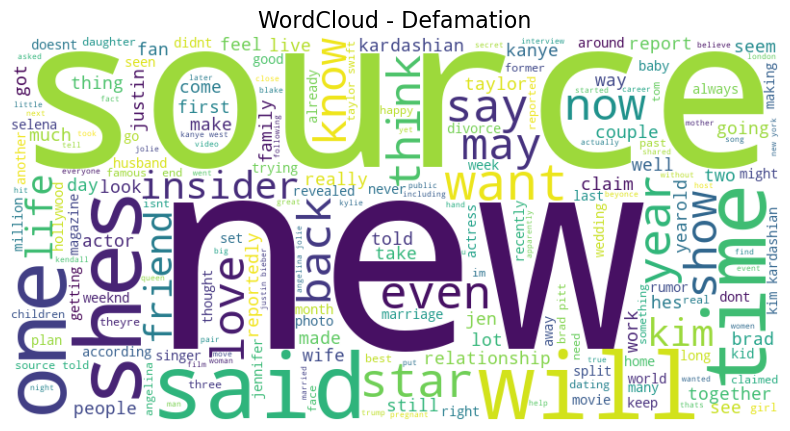

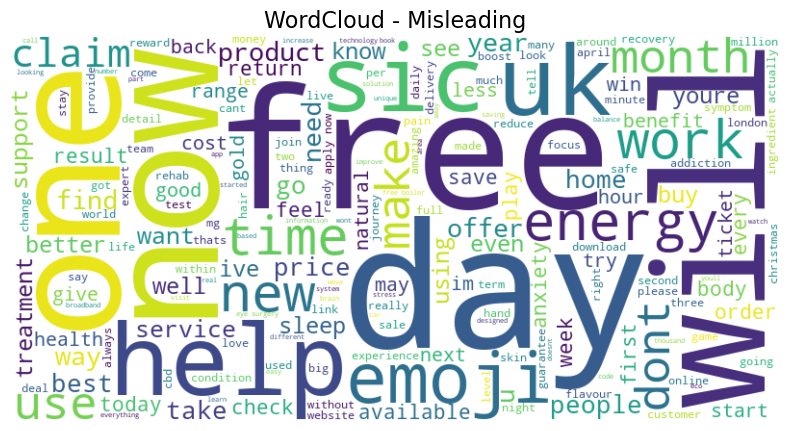

{'Normal': [('the', 12181),
  ('to', 6746),
  ('and', 6409),
  ('of', 5634),
  ('a', 5552),
  ('in', 4258),
  ('i', 3583),
  ('that', 3487),
  ('is', 3186),
  ('it', 2548)],
 'Harassment': [('the', 2938),
  ('a', 2594),
  ('you', 2567),
  ('i', 2374),
  ('to', 2206),
  ('and', 2181),
  ('of', 1772),
  ('is', 1626),
  ('that', 1229),
  ('in', 944)],
 'Defamation': [('the', 3796),
  ('to', 2394),
  ('and', 2130),
  ('a', 1904),
  ('of', 1362),
  ('in', 1290),
  ('her', 1178),
  ('that', 1030),
  ('is', 1021),
  ('with', 948)],
 'Misleading': [('the', 1155),
  ('to', 985),
  ('and', 881),
  ('a', 726),
  ('you', 610),
  ('of', 600),
  ('your', 519),
  ('for', 497),
  ('in', 446),
  ('with', 405)]}

In [2]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import re

# Map label numbers to readable names
label_map = {
    0: "Normal",
    1: "Harassment",
    2: "Defamation",
    3: "Misleading"
}
df['label_name'] = df['label'].map(label_map)

# Clean text for word analysis
def clean_text(text):
    return re.sub(r"[^a-zA-Z@# ]", "", str(text).lower())

df['clean_text'] = df['text'].apply(clean_text)

# Show top 10 words per class
top_words_by_class = {}
for label in df['label_name'].unique():
    words = ' '.join(df[df['label_name'] == label]['clean_text']).split()
    top_words_by_class[label] = Counter(words).most_common(10)

# Generate wordclouds
for label in df['label_name'].unique():
    text = ' '.join(df[df['label_name'] == label]['clean_text'])
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud - {label}", fontsize=16)
    plt.show()

top_words_by_class

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Prepare data
X = df['text']
y = df['label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Pipeline: TF-IDF + Logistic Regression
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=10000, ngram_range=(1, 2))),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

# Train the model
pipeline.fit(X_train, y_train)

# Predict
y_pred = pipeline.predict(X_test)

# Evaluation
report = classification_report(y_test, y_pred, target_names=df['label_name'].unique())
print(report)

              precision    recall  f1-score   support

      Normal       0.86      0.74      0.79       349
  Harassment       0.84      0.81      0.82       252
  Defamation       0.45      0.86      0.59        50
  Misleading       0.78      0.89      0.83        87

    accuracy                           0.79       738
   macro avg       0.73      0.82      0.76       738
weighted avg       0.81      0.79      0.79       738



In [13]:
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

model = SentenceTransformer('all-MiniLM-L6-v2')
X_embeddings = model.encode(df['text'].tolist(), show_progress_bar=True)

X_train, X_test, y_train, y_test = train_test_split(X_embeddings, df['label'], test_size=0.2, random_state=42, stratify=df['label'])

clf = LogisticRegression(max_iter=1000, class_weight='balanced')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

ImportError: cannot import name 'GenerationMixin' from 'transformers.generation' (/opt/miniconda3/envs/cb/lib/python3.13/site-packages/transformers/generation/__init__.py)

In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
# import torch

# Encode labels to integers
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])

# Train-test split
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['text'].tolist(),
    df['label_encoded'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df['label_encoded']
)

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize data
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)

# Convert to Hugging Face Dataset format
train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': train_labels
})

test_dataset = Dataset.from_dict({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask'],
    'labels': test_labels
})

# Load model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    evaluation_strategy="epoch",
    save_strategy="no",
    logging_steps=50,
    load_best_model_at_end=False,
    report_to="none"
)

# Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Train the model
trainer.train()

# Evaluate
preds = trainer.predict(test_dataset)
y_pred = preds.predictions.argmax(axis=1)

# Classification report
report = classification_report(test_labels, y_pred, target_names=label_encoder.classes_.astype(str).tolist())
print(report)

ImportError: 
BertForSequenceClassification requires the PyTorch library but it was not found in your environment. Checkout the instructions on the
installation page: https://pytorch.org/get-started/locally/ and follow the ones that match your environment.
Please note that you may need to restart your runtime after installation.
